In [2]:
import fredpy as fp
import yfinance as yf
from matplotlib import pyplot as plt
import numpy as np
import requests 
import pandas as pd
import ast
import talib as ta
import os
from dotenv import load_dotenv
load_dotenv()
fp.api_key = os.getenv("FREDPY_API_KEY")

Internet connection required. Check connection.


In [11]:
bs = fp.series("WALCL").data.resample("D").ffill() * 1000000
spx = yf.download("^SPX")["Close"]

rrp_raw = requests.get("https://markets.newyorkfed.org/read?productCode=70&startDt=2000-07-01&operationTypes=Reverse%20Repo&eventCodes=730&sort=postDt:1")
rrp_data = [ast.literal_eval(x["data"]) for x in rrp_raw.json()["data"]]
rrp_dates = [pd.Timestamp(x["operationDt"]) for x in rrp_data]
rrp_values = [x["totalAmtAccepted"] for x in rrp_data]
rrp = pd.Series(rrp_values, rrp_dates)
for date in rrp.keys():
    if type(rrp[date]) == pd.Series:
        value = rrp[date].iloc[1]
        rrp.drop(date, inplace = True)
        rrp[date] = value
rrp = rrp.sort_index().resample("D").ffill()

tga_raw = requests.get("https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/dts/dts_table_1?fields=record_date,open_today_bal&filter=account_type:eq:Treasury General Account (TGA) Closing Balance&page[number]=1&page[size]=10000").json()["data"]
tga_dates = [pd.Timestamp(x["record_date"]) for x in tga_raw]
tga_values = [int(x["open_today_bal"]) for x in tga_raw]
tga_new = pd.Series(tga_values, tga_dates).sort_index()
tga_old = fp.series("WTREGEN").data[:tga_new.index[0]] * 1000
tga = pd.concat([tga_old, tga_new]).sort_index().resample("D").ffill() * 1000000

[*********************100%%**********************]  1 of 1 completed


In [12]:
date = pd.Timestamp("2020-04-03")
nl = (bs - tga - rrp)
nl_ = (nl[date:] / nl[date]) * 100
spx_ = (spx[date:] / spx[date]) * 100

In [13]:
nl = nl.dropna()["2009-01-01":]

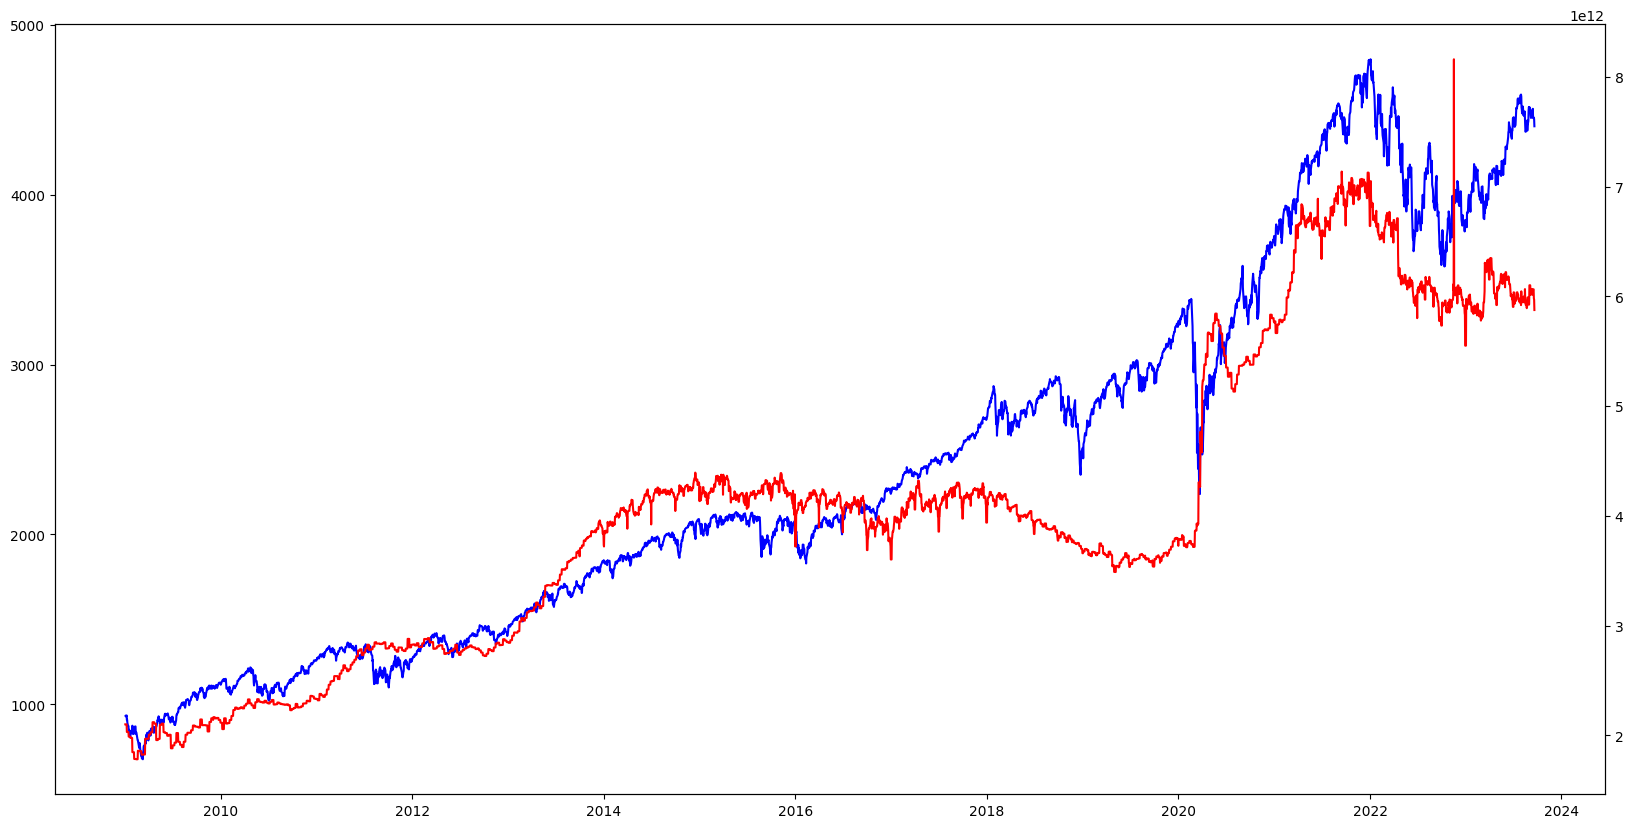

In [14]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(spx[nl.index[0]:nl.index[-1]], color = "blue")
ax2 = ax.twinx()
ax2.plot(nl, color = "red")

In [6]:
np.corrcoef(ta.MA(nl[1:], 40).dropna(), ta.MA(spx[nl.index[0]:nl.index[-1]].resample("D").ffill(), 40).dropna())

/var/folders/0g/0pyvp71x00d07s_b28p42ctc0000gn/T/ipykernel_86624/681651022.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  np.corrcoef(ta.MA(nl[1:], 40).dropna(), ta.MA(spx[nl.index[0]:nl.index[-1]].resample("D").ffill(), 40).dropna())


array([[1.        , 0.93453887],
       [0.93453887, 1.        ]])

In [7]:
len(nl)

5299

In [8]:
len(spx[nl.index[0]:nl.index[-1]].resample("D").ffill())

/var/folders/0g/0pyvp71x00d07s_b28p42ctc0000gn/T/ipykernel_86624/2691048588.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  len(spx[nl.index[0]:nl.index[-1]].resample("D").ffill())


5298